# Dataset analysis

In [2]:
import json
import pandas as pd
# file = open('/home/manuela/Downloads/refcocog-20230409T170358Z-001/refcocog/annotations/refs(umd).p', 'rb')
# obj = pickle.load(file)

path = '../data/raw/refcocog/'
obj = pd.read_pickle(path + 'annotations/refs(umd).p')
refs = json.loads(json.dumps(obj))

with open(path + 'annotations/instances.json', 'r') as file:
    inst = json.load(file)


In [7]:
# images = pd.DataFrame(inst['images'])
# print(images.head())
print(refs[1])
print(inst['info'])
print(inst['images'][0])
print(inst['annotations'][0])
print(inst['categories'])
print(inst['licenses'])
splits = [refs[i]['split'] for i in range(len(refs))]
print(set(splits))
for i in inst:
    print(i)


{'image_id': 419645, 'split': 'test', 'sentences': [{'tokens': ['there', 'is', 'red', 'colored', 'truck', 'in', 'between', 'the', 'other', 'trucks'], 'raw': 'There is red colored truck in between the other trucks', 'sent_id': 10, 'sent': 'there is red colored truck in between the other trucks'}, {'tokens': ['a', 'shiny', 'red', 'vintage', 'pickup', 'truck'], 'raw': 'A shiny red vintage pickup truck', 'sent_id': 11, 'sent': 'a shiny red vintage pickup truck'}], 'file_name': 'COCO_train2014_000000419645_398406.jpg', 'category_id': 8, 'ann_id': 398406, 'sent_ids': [10, 11], 'ref_id': 1}
{'description': 'This is stable 1.0 version of the 2014 MS COCO dataset.', 'url': 'http://mscoco.org', 'version': '1.0', 'year': 2014, 'contributor': 'Microsoft COCO group', 'date_created': '2015-01-27 09:11:52.357475'}
{'license': 1, 'file_name': 'COCO_train2014_000000131074.jpg', 'coco_url': 'http://mscoco.org/images/131074', 'height': 428, 'width': 640, 'date_captured': '2013-11-21 01:03:06', 'flickr_ur

In [5]:
# Check number of images in images, annotations and references
images = set()
for image in inst['images']:
    images.add(image['id'])

img_ann = set()
for ann in inst['annotations']:
    img_ann.add(ann['image_id'])

for ann in inst['annotations']:
    img_ann.add(ann['image_id'])

# img_refs = set(refs['image_id'].unique())

print(len(images), len(img_ann),  len(inst['annotations']))


25799 25799 208960


COCO_train2014_000000060043.jpg
[{'tokens': ['a', 'woman', 'with', 'short', 'blonde', 'hair', 'wearing', 'a', 'blue', 'sweater', 'reaching', 'for', 'condiments'], 'raw': 'A woman with short blonde hair wearing a blue sweater reaching for condiments.', 'sent_id': 3682, 'sent': 'a woman with short blonde hair wearing a blue sweater reaching for condiments'}, {'tokens': ['woman', 'standing', 'wearing', 'grey', 'button', 'up', 'sweater'], 'raw': 'woman standing wearing grey button up sweater', 'sent_id': 3683, 'sent': 'woman standing wearing grey button up sweater'}]


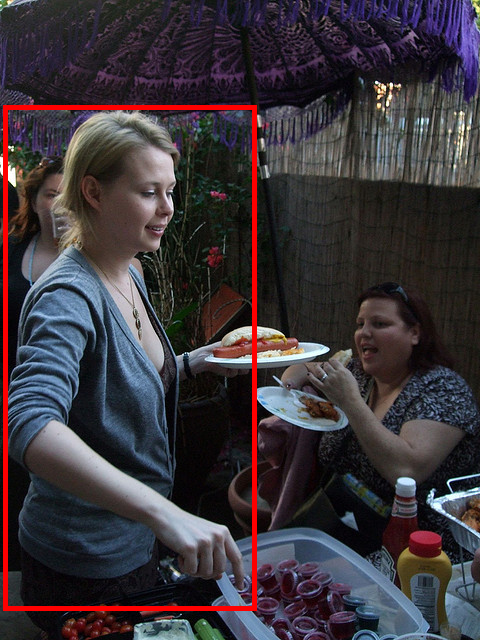

In [16]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.ops import box_convert
ref = refs[157]

# print(ref['file_name']) remove the annotation id from name
bbox = [ann['bbox'] for ann in inst['annotations'] if ann['id'] == ref['ann_id']][0]
# print(bbox)
image_name = '_'.join(ref['file_name'].split('_')[0:-1]) + '.jpg'
print(image_name)
box = box_convert(torch.tensor([bbox]), in_fmt='xywh', out_fmt='xyxy')
# print(box.shape)
print(ref['sentences'])
image = read_image(path + 'images/'+image_name)
res = draw_bounding_boxes(image, boxes=box, colors='red', width=5)
t.ToPILImage()(res)


In [5]:
class Example():
    def __init__(self, id:str, split:str, sentences:list, image_id:str, file_name:str, category:dict, bbox:torch.Tensor) -> None:
        self.id = id
        self.split = split
        self.sentences = sentences
        self.image_id = image_id
        self.file_name = file_name
        self.category = category
        self.bbox = bbox
    
    def __str__(self):
        return f'''
[
    Id: {self.id},
    Split: {self.split},
    Sentences: {self.sentences},
    Image: {self.file_name},
    Category: {self.category['name']}
]'''

# example:Example = Example()
examples = []
for ref in refs[0:100]:
    sentences = []
    for sentence in ref['sentences']:
        sentences.append({
            'tokens': sentence['tokens'], 
            'sent': sentence['sent']
        })
    file_name = '_'.join(ref['file_name'].split('_')[0:-1]) + '.jpg'
    category = [{'category_id': cat['id'], 'name': cat['name']} for cat in inst['categories'] if cat['id'] == ref['category_id']][0]
    bbox = [ann['bbox'] for ann in inst['annotations'] if ann['id'] == ref['ann_id']][0]
    box = box_convert(torch.tensor([bbox]), in_fmt='xywh', out_fmt='xyxy')
    
    e = Example(ref['ref_id'], 
                    ref['split'], 
                    sentences,
                    ref['image_id'],
                    file_name,
                    category,
                    box)
    examples.append(e)



In [6]:
print(examples[0])



[
    Id: 0,
    Split: test,
    Sentences: [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'sent': 'skiier in red pants'}],
    Image: COCO_train2014_000000380440.jpg,
    Category: person
]
